In [1]:
# TODO: plot all the historical portfolios vs act stocks

In [2]:
# UNCOMMENT BELOW:::::::::::::::::::::::::::::::::::::::::::
# import ipynb.fs.full.funcs as om




# ERR: MPT-Portfo\funcs.ipynb", line 139

# File "C:\Users\0\PycharmProjects\MPT-Portfo\funcs.ipynb", line 139
#     "source": []
#     ^
# SyntaxError: invalid syntax

           LNG       SPY      SMLV
LNG   0.000366  0.000192  0.000146
SPY   0.000192  0.000173  0.000127
SMLV  0.000146  0.000127  0.000103


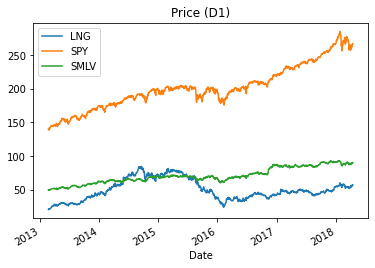

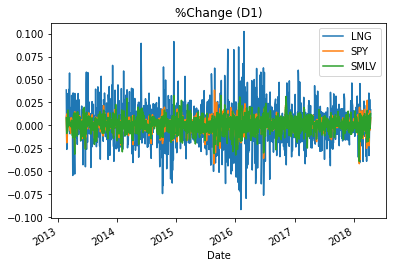

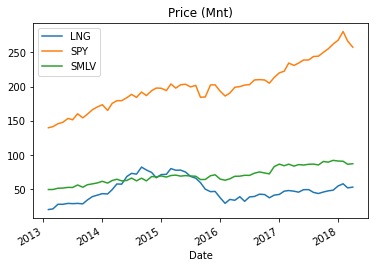

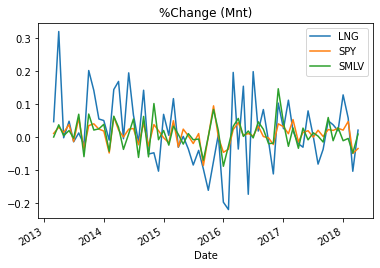

In [3]:
stocks = ['LNG','SPY','SMLV']

import pandas as pd
lng_df = pd.read_csv('lng.csv', index_col=0, header=0, names=['Date','LNG','LNGVOL']).drop('LNGVOL',axis=1)
spy_df = pd.read_csv('spy.csv', index_col=0, header=0, names=['Date','SPY','SPYVOL']).drop('SPYVOL',axis=1)
smlv_df = pd.read_csv('smlv.csv', index_col=0, header=0, names=['Date','SMLV','SMLVVOL']).drop('SMLVVOL',axis=1)

# Join 3 stock dataframes together
full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()
full_df.index = pd.to_datetime(full_df.index)
full_df.index.names = ['Date']

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()

full_df.plot(title='Price (D1)')
returns_daily.plot(title='%Change (D1)')
monthly_df.plot(title='Price (Mnt)')
returns_monthly.plot(title='%Change (Mnt)')




# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])



# UNCOMMENT BELOW:::::::::::::::::::::::::::::::::::::::::::
# dftmp = pd.DataFrame(covariances[i])
# # dftmp.plot(title='Last Cov @ {}'.format(i), marker='.')
# om.plotHeatmap(dftmp, ttl='Last Cov @ {}'.format(i), nrows=5, ncols=5, dfHasCorr=True)

In [4]:
cntportfos = 1000
cntstocks = returns_monthly.shape[1]
minreturnlimit, minreturn = False, 0.01 



portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    
    import numpy as np
    for portfolio in range(cntportfos):
        weights = np.random.random(cntstocks)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        if minreturnlimit and returns<minreturn: continue
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print('First(Lowest Risk) recent portfo weights',portfolio_weights[date][0])
print('Last(Highest Return) recent portfo weights',portfolio_weights[date][0])



# # Get latest date of available data
# date = sorted(covariances.keys())[-1] 

# # Plot efficient frontier
# # warning: this can take at least 10s for the plot to execute...
# from matplotlib import pyplot as plt
# plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.1)
# plt.xlabel('Volatility')
# plt.ylabel('Returns')
# plt.show()

First(Lowest Risk) recent portfo weights [0.50572051 0.34399337 0.15028612]
Last(Highest Return) recent portfo weights [0.50572051 0.34399337 0.15028612]


Recent Optim Portfo Return: 0.01630639084445365


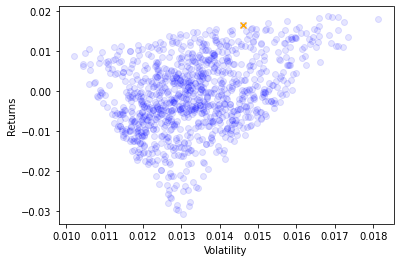

cur_returns[best_idx] 0.01630639084445365
cur_volatility[best_idx] 0.014609000317058989
date 2018-04-02 00:00:00
best_idx 815
portfolio_weights[date][best_idx] [0.58362843 0.00221317 0.4141584 ]


In [9]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])
    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print('Recent Optim Portfo Return:',portfolio_returns[date][max_sharpe_idxs[date]])





# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
from matplotlib import pyplot as plt
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

print('cur_returns[best_idx]',cur_returns[best_idx])
print('cur_volatility[best_idx]',cur_volatility[best_idx])

print('date',date)
print('best_idx',best_idx)

print('portfolio_weights[date][best_idx]',portfolio_weights[date][best_idx])

In [10]:
maperiod = 30


# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=maperiod).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print('Last Month Price EWMA({}D):'.format(maperiod))
print(ewma_monthly.iloc[-1])
print('')



targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
# print(targets[-5:])

print('Target= Optimised Portfo Weights each Month\n',pd.DataFrame(targets, columns=stocks))
print('')
print('Features= Price EwMA(30D) each Month\n',pd.DataFrame(features, columns=stocks))

Last Month Price EWMA(30D):
LNG    -0.004304
SPY    -0.001003
SMLV   -0.001670
Name: 2018-04-02 00:00:00, dtype: float64

Target= Optimised Portfo Weights each Month
          LNG       SPY      SMLV
0   0.271505  0.715377  0.013118
1   0.955778  0.034323  0.009900
2   0.034685  0.915181  0.050134
3   0.013333  0.952577  0.034090
4   0.981180  0.010779  0.008041
..       ...       ...       ...
57  0.043873  0.947388  0.008739
58  0.848716  0.147576  0.003708
59  0.403461  0.593920  0.002619
60  0.014977  0.952777  0.032246
61  0.583628  0.002213  0.414158

[62 rows x 3 columns]

Features= Price EwMA(30D) each Month
          LNG       SPY      SMLV
0   0.038595  0.009773  0.008058
1   0.006870  0.002056  0.000039
2   0.013170  0.001171  0.000966
3   0.004331  0.000800  0.000598
4   0.000820  0.000626  0.000044
..       ...       ...       ...
57  0.002789  0.000925 -0.000038
58  0.001067  0.001504  0.001337
59  0.006037  0.001228  0.000157
60  0.003666  0.001327 -0.000560
61 -0.004304

In [13]:
# IMP (RandomForest): usually good model most times, 
# also TRAIN score improvment stops after n_estim=100 but TEST score still improves
cnttrees=300

# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=cnttrees, random_state=42)
rfr.fit(train_features, train_targets)
print('TRAIN Score:', rfr.score(train_features, train_targets))
print('TEST Score:', rfr.score(test_features, test_targets))
print('')



print('TRAIN----------Target= Optimised Portfo Weights each Month\n',pd.DataFrame(train_targets, columns=stocks))
print('')
print('TRAIN----------Features= Price EWMA(30D) each Month\n',pd.DataFrame(train_features, columns=stocks))
print('')
print('TEST----------Target= Optimised Portfo Weights each Month\n',pd.DataFrame(test_targets, columns=stocks))
print('')
print('TEST----------Features= Price EWMA(30D) each Month\n',pd.DataFrame(test_features, columns=stocks))

TRAIN Score: 0.8267625032963014
TEST Score: -0.4928432196841351

TRAIN----------Target= Optimised Portfo Weights each Month
          LNG       SPY      SMLV
0   0.271505  0.715377  0.013118
1   0.955778  0.034323  0.009900
2   0.034685  0.915181  0.050134
3   0.013333  0.952577  0.034090
4   0.981180  0.010779  0.008041
5   0.000035  0.498495  0.501469
6   0.961561  0.010215  0.028224
7   0.784865  0.002355  0.212780
8   0.125959  0.851372  0.022669
9   0.094544  0.686518  0.218937
10  0.037922  0.012078  0.950000
11  0.951085  0.033639  0.015276
12  0.211803  0.784177  0.004020
13  0.935070  0.006286  0.058644
14  0.260225  0.739060  0.000715
15  0.412061  0.586451  0.001487
16  0.005638  0.039225  0.955137
17  0.812638  0.183487  0.003875
18  0.093577  0.160581  0.745841
19  0.961561  0.034506  0.003933
20  0.002819  0.327080  0.670102
21  0.024931  0.926191  0.048878
22  0.731691  0.004182  0.264127
23  0.916769  0.052988  0.030243
24  0.554501  0.443362  0.002137
25  0.095987  0.0

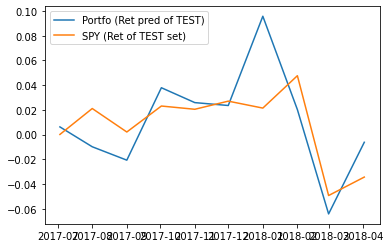

algo returns: 0.10559095642846046
SPY returns: 0.07811831329855999


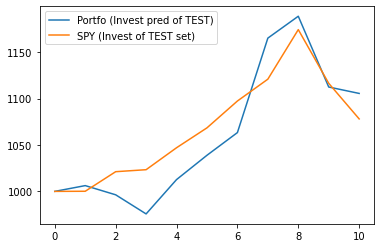

IMP: Portfo MODEL is compared with S&P MARKET-INDEX but not much better, need to add MORE FEATURES


In [14]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features) 

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='Portfo (Ret pred of TEST)')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY (Ret of TEST set)')
plt.legend()
plt.show()




# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])


# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='Portfo (Invest pred of TEST)')
plt.plot(spy_cash, label='SPY (Invest of TEST set)')
plt.legend()  # show the legend
plt.show()



# IMP: Portfo MODEL is compared with S&P MARKET-INDEX but not much better, need to add MORE FEATURES
print('IMP: Portfo MODEL is compared with S&P MARKET-INDEX but not much better, need to add MORE FEATURES')

# IMP: Real-world big data use: 
# Parallel processing LIBS (Python multiprocess, Dask, Spark)
# Cloud (AWS, ...)
# Big Datasets from quandl.com/EOD
# Use Alternative Data coz price is not enough for prediction:
# - Sattelite imgs for shipping vol, 
# - PsychSignal social media sentiment analysis,
# - expert analyst preds
# - fundamentals data
# - dont forget to test on TEST data
# - use model to invest only on low-cost ETFs not stocks
